In [73]:
import numpy as np
import pandas as pd
from datetime import datetime
from time import time
import itertools
import scipy.stats as stats
from src.functions import *
import textwrap
import tensorflow as tf
from tensorflow import keras
import statsmodels.api as sm

from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, silhouette_samples, mean_squared_error, mean_absolute_error
from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold, train_test_split, cross_validate, cross_val_score, permutation_test_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Perceptron
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor

import matplotlib.cm as cm
import seaborn as sn
from dateutil.relativedelta import relativedelta

from sportsreference.nba.boxscore import Boxscore
from sportsreference.nba.roster import Roster, Player
from sportsreference.nba.schedule import Schedule
from sportsreference.nba.teams import Teams

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [2]:
df_season = pd.read_csv('data/2nba_player_stats_by_season.csv')

/home/luke/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3147: DtypeWarning: Columns (102) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
df_season[['id', 'height', 'year', 'team_abbreviation', 'age', 'player_id']]

id height  year team_abbreviation        age  player_id
0      bareajo01 2007   5-10  2007               DAL  22.500000  bareajo01
1      bareajo01 2008   5-10  2008               DAL  23.500000  bareajo01
2      bareajo01 2009   5-10  2009               DAL  24.500000  bareajo01
3      bareajo01 2010   5-10  2010               DAL  25.500000  bareajo01
4      bareajo01 2011   5-10  2011               DAL  26.500000  bareajo01
...               ...    ...   ...               ...        ...        ...
13230  reevekh01 1997    6-3  1997               TOT  24.416667  reevekh01
13231  reevekh01 1998    6-3  1998               DAL  25.416667  reevekh01
13232  reevekh01 1999    6-3  1999               DET  26.416667  reevekh01
13233  reevekh01 2000    6-3  2000               CHI  27.416667  reevekh01
13234  willode01 2000    6-3  2000               CHI  25.583333  willode01

[13235 rows x 6 columns]

# Dropping Columns

In [4]:
drop_lst = []

for col in df_season.columns:
    unique = df_season[col].unique()
    val = len(unique)
    if val <= 1:
        drop_lst.append(str(col))
        print(f'{col}: has {val} values')
        print(f'Values include:')
        print(f'     {unique}')

print(f'Drop List: {drop_lst}')

and_ones: has 1 values
Values include:
     [nan]
blocking_fouls: has 1 values
Values include:
     [nan]
center_percentage: has 1 values
Values include:
     [0]
dunks: has 1 values
Values include:
     [nan]
lost_ball_turnovers: has 1 values
Values include:
     [nan]
net_plus_minus: has 1 values
Values include:
     [nan]
offensive_fouls: has 1 values
Values include:
     [nan]
on_court_plus_minus: has 1 values
Values include:
     [nan]
other_turnovers: has 1 values
Values include:
     [nan]
passing_turnovers: has 1 values
Values include:
     [nan]
percentage_field_goals_as_dunks: has 1 values
Values include:
     [nan]
percentage_of_three_pointers_from_corner: has 1 values
Values include:
     [nan]
percentage_shots_three_pointers: has 1 values
Values include:
     [nan]
percentage_shots_two_pointers: has 1 values
Values include:
     [nan]
point_guard_percentage: has 1 values
Values include:
     [0]
points_generated_by_assists: has 1 values
Values include:
     [nan]
power_for

In [5]:
df_season = df_season.drop(drop_lst, axis=1)
df_season = df_season.drop('id', axis=1)

# Row work

In [6]:
def to_inches(height):
    feet, inches = str(height).split('-')
    return (int(feet)*12) + int(inches)

In [7]:
df_season['height'] = df_season['height'].apply(to_inches)

In [8]:
player_names = df_season['name'].unique()
type(player_names)

numpy.ndarray

# Filling NaN's

In [9]:
# Making copy of df_season and going to continue working with that one in place (13235 rows)
df_copy = df_season.copy()

In [10]:
# Players in season df that were paid but did not play
df_paid_not_played = df_season[df_season['minutes_played'].isna()]

# removed 658 rows reduced to 12577 after removing players that did not play (don't want to skew data)
df_season = df_season.drop(df_paid_not_played.index)

In [11]:
# Removed 1072 down to 11495
# Some players don't have a recorded salary, going to seperate those out to their own df
df_season = df_season[df_season['salary'] >= 100]

In [12]:
# Filling nan for position with 'na' & then the rest of the categories with 0's
# because they're only nan's since they haven't attempted
df_season['position'] = df_season['position'].fillna('na')

In [13]:
# Creating current/past players DF's & then dropping the columns that only pertain to current players from career_df
df_past_players = df_season[df_season['current_player'] == False]
#df_past_players
df_current_players = df_season[df_season['current_player'] == True]
#df_current_players
current_player_features = ['contract_total', 'contract_length', 'current_salary', 'current_avg_salary', 'current_team']
df_season = df_season.drop(current_player_features, axis=1)

In [14]:
# Filling nans with 0's since the rest mean that nothing was attempted from what I could tell
df_season = df_season.fillna(0)

In [15]:
non_stats = ['salary', 'year','nationality', 'position', 'birth_date', 'year_list', 'team_abbreviation', 'player_id', 'name', 'salary']

df_pure_stats = df_season.drop(non_stats, axis=1)

In [16]:
df_pure_stats.shape

(11495, 62)

In [17]:
df_pure_stats = df_pure_stats.astype('float64')

# Sanity Check

In [18]:
df_pure_stats.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11495 entries, 0 to 13234
Data columns (total 62 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   assist_percentage                               11495 non-null  float64
 1   assists                                         11495 non-null  float64
 2   block_percentage                                11495 non-null  float64
 3   blocks                                          11495 non-null  float64
 4   box_plus_minus                                  11495 non-null  float64
 5   defensive_box_plus_minus                        11495 non-null  float64
 6   defensive_rebound_percentage                    11495 non-null  float64
 7   defensive_rebounds                              11495 non-null  float64
 8   defensive_win_shares                            11495 non-null  float64
 9   effective_field_goal_percentage        

# Exploratory Graphs

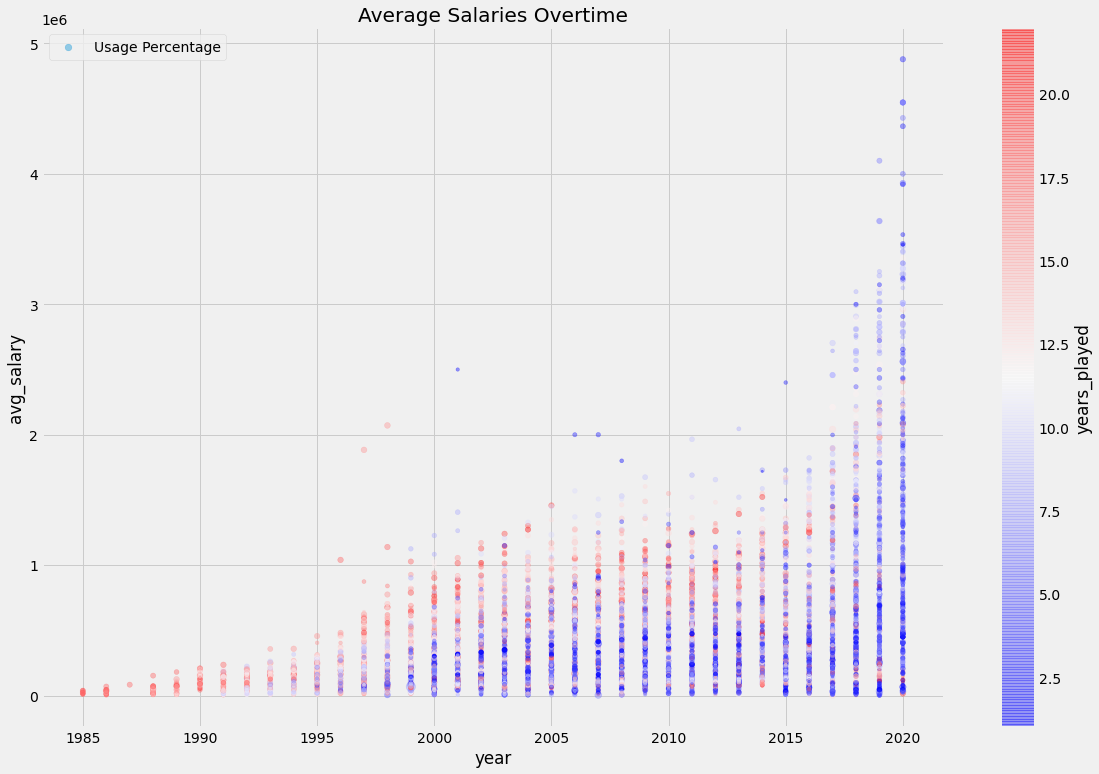

In [19]:
df_season.plot(kind="scatter", x="year", y="avg_salary", alpha=0.4,
             s='usage_percentage', label="Usage Percentage", figsize=(18,12),
             c="years_played", cmap=plt.get_cmap("bwr"), colorbar=True,
             title='Average Salaries Overtime')
plt.legend()
plt.savefig('images/avg_salaries_overtime.png')

# Looking for correlations

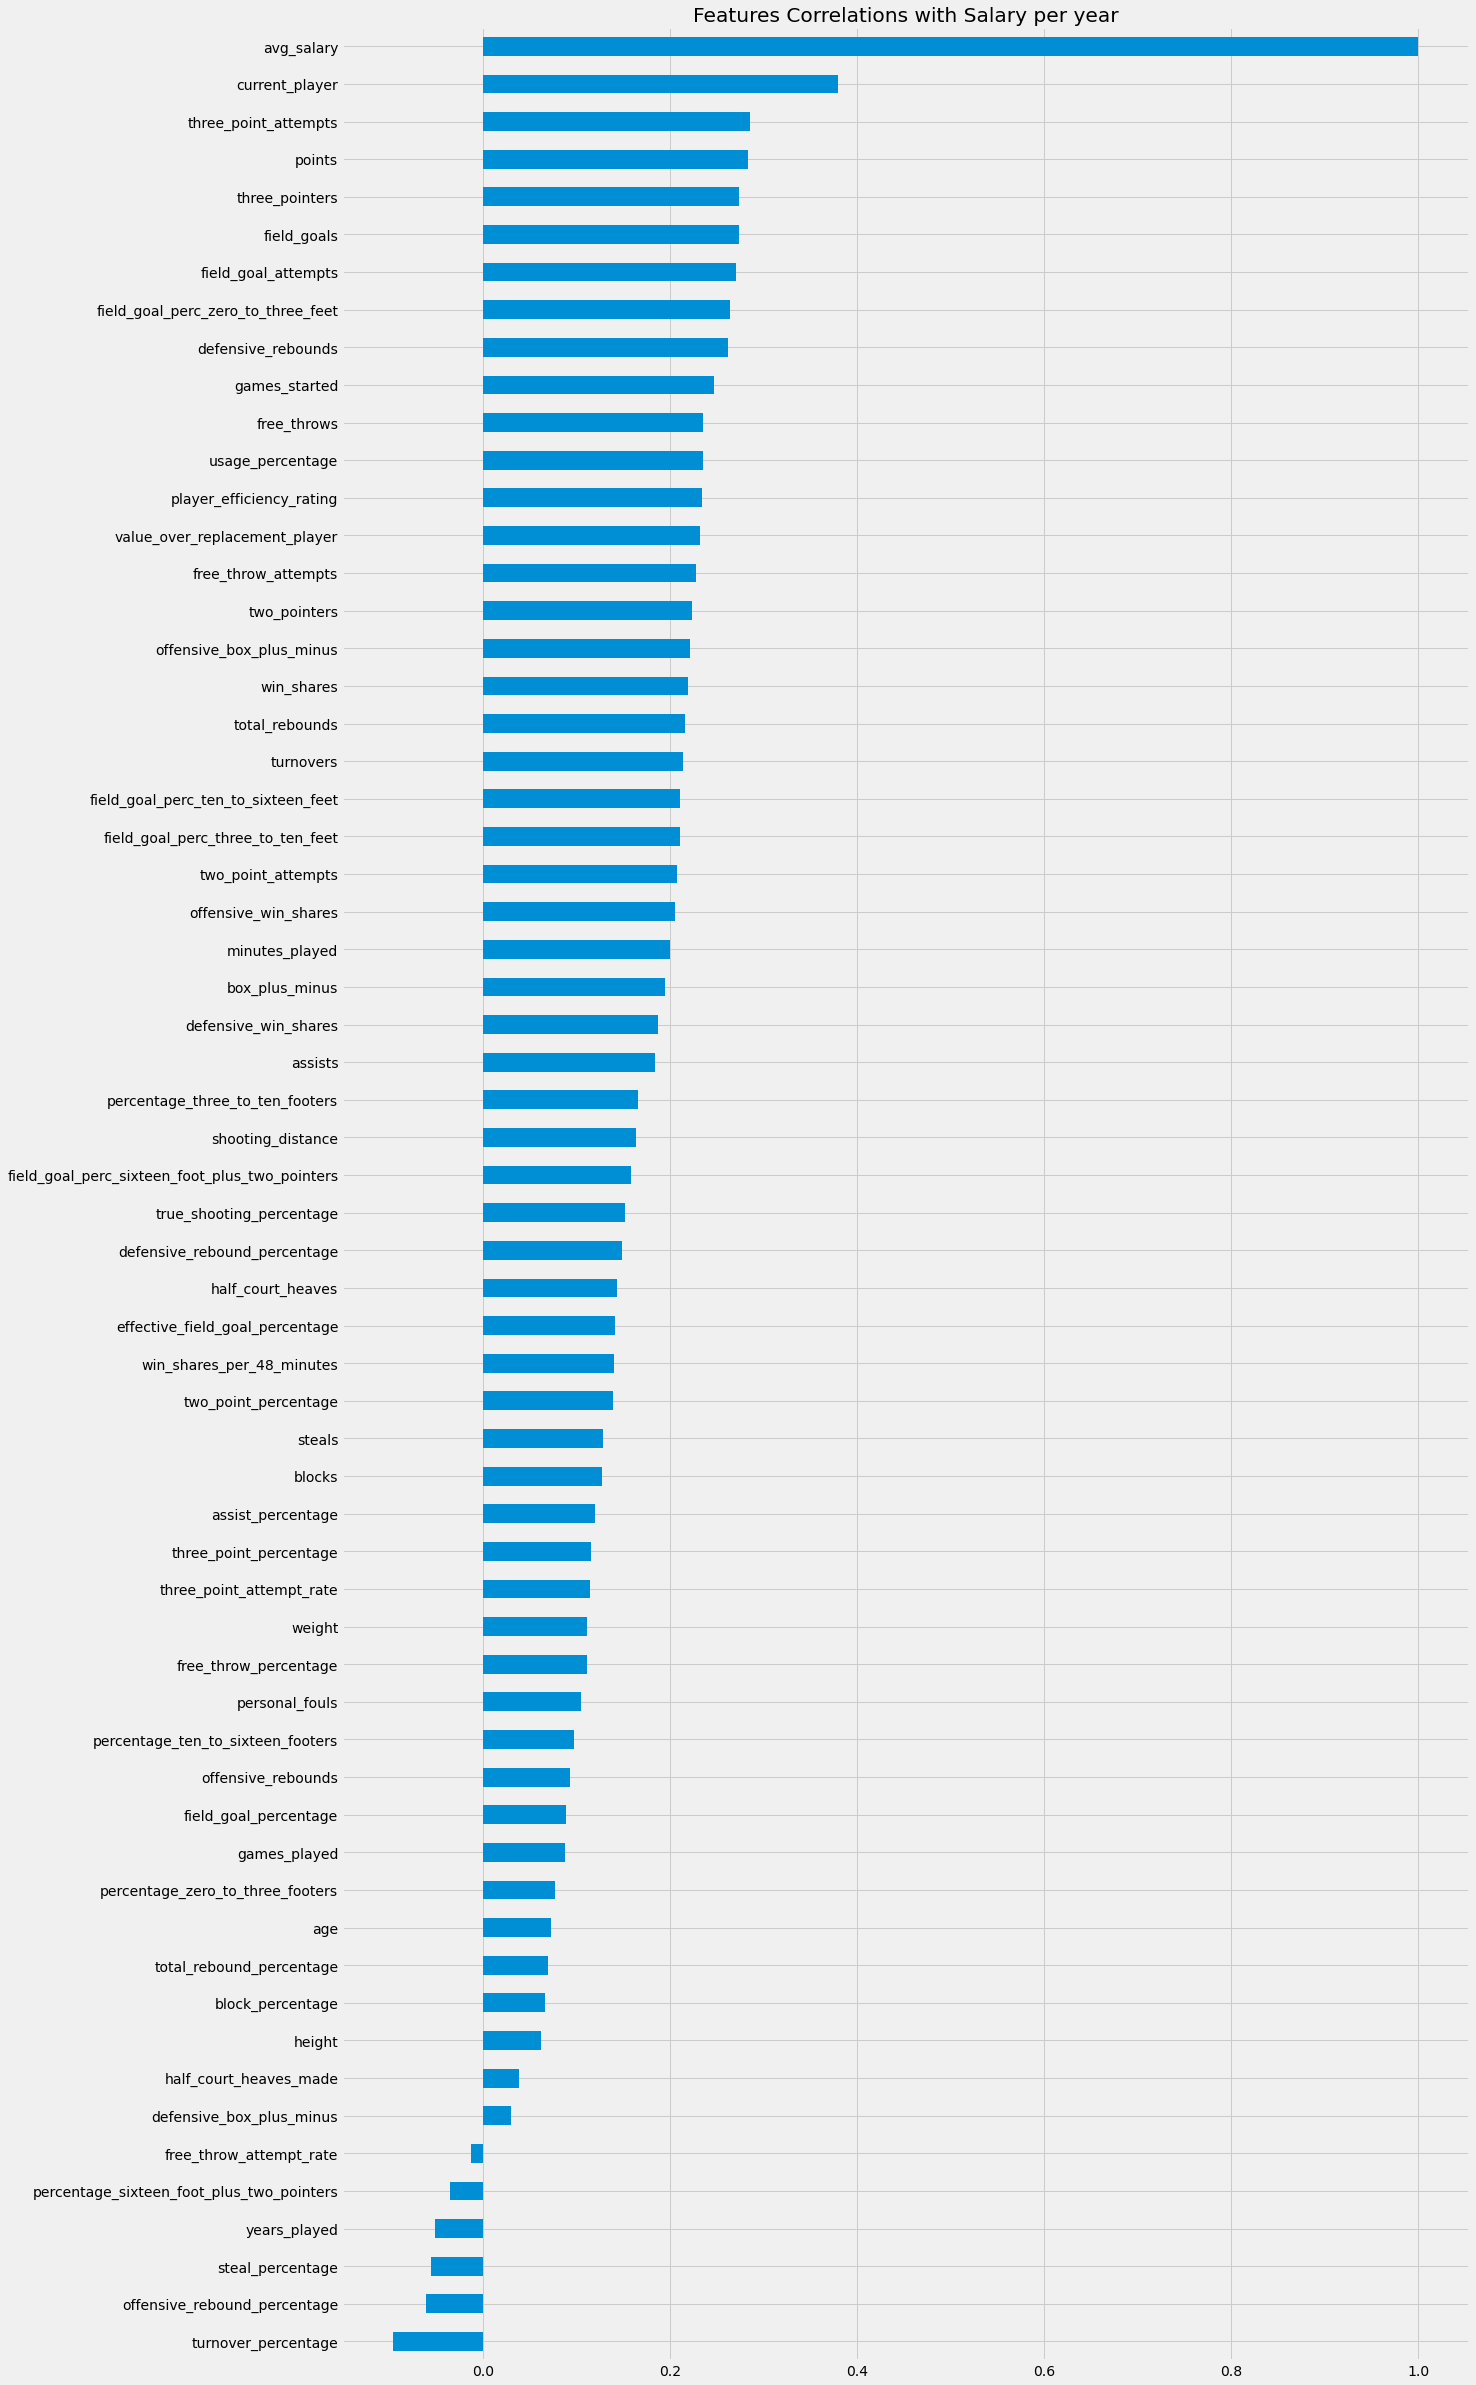

In [20]:
corr_matrix = df_pure_stats.corr()
corr_matrix['avg_salary'].sort_values(ascending=True).plot(title='Features Correlations with Salary per year', kind='barh', figsize=(18,40))
plt.savefig('images/feature_correlation.png')

# Train_test_splitting

In [74]:
y = df_pure_stats['avg_salary'].copy()
X = df_pure_stats.drop('avg_salary', axis=1)

In [75]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [76]:
salary_median = y_train.median()
salary_median

253398.66666666663

In [77]:
salary_mean = y_train.mean()
salary_mean

404172.6855562807

In [83]:
model = sm.OLS(y_train, X_train)
results = model.fit()
print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:             avg_salary   R-squared (uncentered):                   0.666
Model:                            OLS   Adj. R-squared (uncentered):              0.664
Method:                 Least Squares   F-statistic:                              319.5
Date:                Wed, 31 Mar 2021   Prob (F-statistic):                        0.00
Time:                        18:15:14   Log-Likelihood:                     -1.3063e+05
No. Observations:                9196   AIC:                                  2.614e+05
Df Residuals:                    9139   BIC:                                  2.618e+05
Df Model:                          57                                                  
Covariance Type:            nonrobust                                                  
                                                     coef    std err          t      P>|t|      [0.025      0.975]
-----

# Linear Regression

In [78]:
lin_model = LinearRegression().fit(X_train, y_train)

In [79]:
salary_predictions = lin_model.predict(X_train)
lin_mse = mean_squared_error(y_train, salary_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

355426.4486750489

In [80]:
lin_mae = mean_absolute_error(y_train, salary_predictions)
lin_mae

238740.14742488324

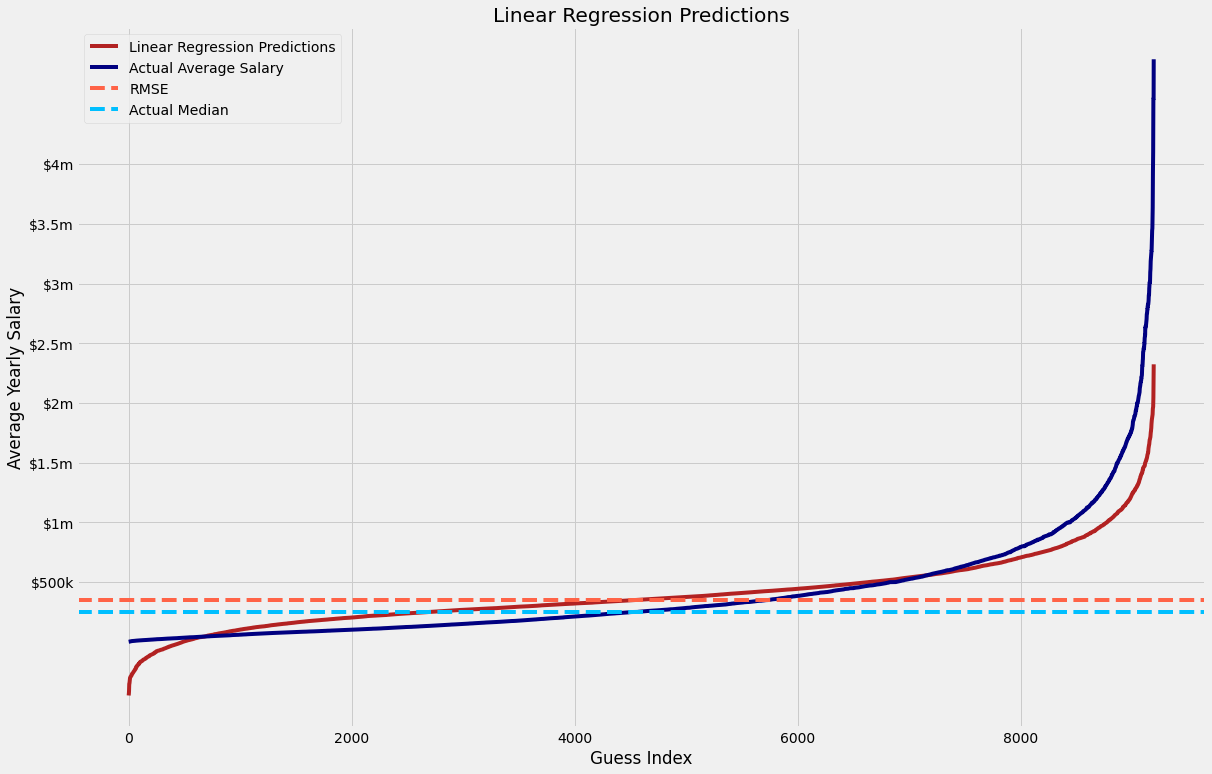

In [30]:
fig, ax = plt.subplots(figsize=(18,12))

ax.plot(np.sort(salary_predictions), label='Linear Regression Predictions', c='firebrick')
ax.plot(np.sort(y_train), label='Actual Average Salary', c='navy')
ax.axhline(lin_rmse, linestyle='--', label='RMSE',c='tomato')
ax.axhline(salary_median, linestyle='--', label='Actual Median', c='deepskyblue')
ax.set_yticks(ticks=[500000, 1000000, 1500000, 2000000, 2500000, 3000000, 3500000, 4000000])
ax.set_yticklabels(['$500k','$1m','$1.5m','$2m','$2.5m','$3m','$3.5m', '$4m'])
ax.set_ylabel('Average Yearly Salary')
ax.set_xlabel('Guess Index')
ax.set_title('Linear Regression Predictions')

plt.legend()
plt.savefig('images/linear_regression.png')

# Neural Networkings

In [47]:
X_train_full, X_test, y_train_full, y_test = train_test_split(X.values, y.values, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

In [48]:
np.random.seed(42)
tf.random.set_seed(42)

In [59]:
input_A = keras.layers.Input(shape=[5], name="wide_input")
input_B = keras.layers.Input(shape=[59], name="deep_input")
hidden1 = keras.layers.Dense(30, activation="relu")(input_B)
hidden2 = keras.layers.Dense(30, activation="relu")(hidden1)
concat = keras.layers.concatenate([input_A, hidden2])
output = keras.layers.Dense(1, name="output")(concat)
aux_output = keras.layers.Dense(1, name="aux_output")(hidden2)
model = keras.models.Model(inputs=[input_A, input_B], outputs=[output, aux_output])

In [61]:
model.compile(loss=["mse", "mse"], loss_weights=[0.9, 0.1], optimizer=keras.optimizers.SGD(lr=1e-3))

X_train_A, X_train_B = X_train[:, :5], X_train[:, 2:]
X_valid_A, X_valid_B = X_valid[:, :5], X_valid[:, 2:]
X_test_A, X_test_B = X_test[:, :5], X_test[:, 2:]
X_new_A, X_new_B = X_test_A[:3], X_test_B[:3]

history = model.fit([X_train_A, X_train_B], [y_train, y_train], epochs=20,
                    validation_data=([X_valid_A, X_valid_B], [y_valid, y_valid]))
total_loss, main_loss, aux_loss = model.evaluate([X_test_A, X_test_B], [y_test, y_test])
y_pred_main, y_pred_aux = model.predict([X_new_A, X_new_B])

Epoch 1/20
203/203 [==============================] - 1s 2ms/step - loss: 957903201395357312.0000 - output_loss: 1062879962357566336.0000 - aux_output_loss: 13112728154306520.0000 - val_loss: 49568016236544.0000 - val_output_loss: 55028005994496.0000 - val_aux_output_loss: 428141543424.0000
Epoch 2/20
203/203 [==============================] - 0s 1ms/step - loss: 40361663433868.5469 - output_loss: 44795450596251.6094 - aux_output_loss: 457635343821.8039 - val_loss: 22540953059328.0000 - val_output_loss: 25000016871424.0000 - val_aux_output_loss: 409317146624.0000
Epoch 3/20
203/203 [==============================] - 0s 1ms/step - loss: 19158245408125.4883 - output_loss: 21236950350265.7266 - aux_output_loss: 449887050972.8627 - val_loss: 10838894182400.0000 - val_output_loss: 11999653134336.0000 - val_aux_output_loss: 392046739456.0000
Epoch 4/20
203/203 [==============================] - 0s 1ms/step - loss: 9241173875932.8633 - output_loss: 10219148670453.9609 - aux_output_loss: 43940

In [69]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[0, 61]),
    keras.layers.Dense(1)
])

In [70]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          (None, 0)                 0         
_________________________________________________________________
dense_22 (Dense)             (None, 300)               300       
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 300)               0         
_________________________________________________________________
dense_23 (Dense)             (None, 100)               30100     
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 100)               0         
_________________________________________________________________
dense_24 (Dense)             (None, 10)                1010      
Total params: 31,410
Trainable params: 31,410
Non-trainable params: 0
__________________________________________________

In [71]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])

In [72]:
history = model.fit(X_train, y_train, epochs=10,validation_data=(X_valid, y_valid))

Epoch 1/10


ValueError: in user code:

    /home/luke/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:805 train_function  *
        return step_function(self, iterator)
    /home/luke/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:795 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /home/luke/anaconda3/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /home/luke/anaconda3/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:2730 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /home/luke/anaconda3/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:3417 _call_for_each_replica
        return fn(*args, **kwargs)
    /home/luke/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:788 run_step  **
        outputs = model.train_step(data)
    /home/luke/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:754 train_step
        y_pred = self(x, training=True)
    /home/luke/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/base_layer.py:1012 __call__
        outputs = call_fn(inputs, *args, **kwargs)
    /home/luke/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:375 call
        return super(Sequential, self).call(inputs, training=training, mask=mask)
    /home/luke/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/functional.py:425 call
        inputs, training=training, mask=mask)
    /home/luke/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/functional.py:560 _run_internal_graph
        outputs = node.layer(*args, **kwargs)
    /home/luke/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/base_layer.py:998 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    /home/luke/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/input_spec.py:259 assert_input_compatibility
        ' but received input with shape ' + display_shape(x.shape))

    ValueError: Input 0 of layer dense_22 is incompatible with the layer: expected axis -1 of input shape to have value 0 but received input with shape (None, 61)


In [ ]:
'''Trains a simple convnet on the MNIST dataset.
based on a keras example by fchollet
Find a way to improve the test accuracy to almost 99%!
FYI, the number of layers and what they do is fine.
But their parameters and other hyperparameters could use some work.
'''
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
import numpy as np
np.random.seed(1337)  # for reproducibility

def load_and_featurize_data():
    # the data, shuffled and split between train and test sets
    (X_train, y_train), (X_test, y_test) = train_test_split(X.values, y.values)

    # reshape input into format Conv2D layer likes
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)

    # don't change conversion or normalization
    X_train = X_train.astype('float32')  # data was uint8 [0-255]
    X_test = X_test.astype('float32')    # data was uint8 [0-255]
    X_train /= 255  # normalizing (scaling from 0 to 1)
    X_test /= 255   # normalizing (scaling from 0 to 1)

    print('X_train shape:', X_train.shape)
    print(X_train.shape[0], 'train samples')
    print(X_test.shape[0], 'test samples')

    # convert class vectors to binary class matrices (don't change)
    Y_train = to_categorical(y_train, nb_classes)  # cool
    Y_test = to_categorical(y_test, nb_classes)
    
    # in Ipython you should compare Y_test to y_test
    return X_train, X_test, Y_train, Y_test


def define_model(nb_filters, kernel_size, input_shape, pool_size):
    model = Sequential()  # model is a linear stack of layers (don't change)

    # note: the convolutional layers and dense layers require an activation function
    # see https://keras.io/activations/
    # and https://en.wikipedia.org/wiki/Activation_function
    # options: 'linear', 'sigmoid', 'tanh', 'relu', 'softplus', 'softsign'

    model.add(Conv2D(nb_filters,
                     (kernel_size[0], kernel_size[1]),
                     padding='valid',
                     input_shape=input_shape))  # first conv. layer  KEEP
    
    model.add(Activation('relu'))  # Activation specification necessary for Conv2D and Dense layers

    model.add(Conv2D(nb_filters,
                     (kernel_size[0], kernel_size[1]),
                     padding='valid'))  # 2nd conv. layer KEEP
    
    model.add(Activation('relu'))

    model.add(MaxPooling2D(pool_size=pool_size))  # decreases size, helps prevent overfitting
    model.add(Dropout(0.3))  # zeros out some fraction of inputs, helps prevent overfitting
    
    # Adding another layer
    model.add(Conv2D(nb_filters,
                     (kernel_size[0], kernel_size[1]),
                     padding='valid',
                     input_shape=input_shape))  # first conv. layer  KEEP
    
    model.add(Activation('relu'))  # Activation specification necessary for Conv2D and Dense layers

    model.add(Conv2D(nb_filters,
                     (kernel_size[0], kernel_size[1]),
                     padding='valid'))  # 2nd conv. layer KEEP
    
    model.add(Activation('relu'))

    model.add(MaxPooling2D(pool_size=pool_size))  # decreases size, helps prevent overfitting
    model.add(Dropout(0.3))  # zeros out some fraction of inputs, helps prevent overfitting

    model.add(Flatten())  # necessary to flatten before going into conventional dense layer  KEEP
    print('Model flattened out to ', model.output_shape)

    # now start a typical neural network
    model.add(Dense(32))  # (only) 32 neurons in this layer, really?   KEEP
    model.add(Activation('relu'))

    model.add(Dropout(0.3))  # zeros out some fraction of inputs, helps prevent overfitting

    model.add(Dense(nb_classes))  # 10 final nodes (one for each class)  KEEP
    model.add(Activation('softmax'))  # softmax at end to pick between classes 0-9 KEEP

    # many optimizers available, see https://keras.io/optimizers/#usage-of-optimizers
    # suggest you KEEP loss at 'categorical_crossentropy' for this multiclass problem,
    # and KEEP metrics at 'accuracy'
    # suggest limiting optimizers to one of these: 'adam', 'adadelta', 'sgd'
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    return model


if __name__ == '__main__':
    # important inputs to the model: don't changes the ones marked KEEP
    img_rows, img_cols = 28, 28   # the size of the MNIST images KEEP
    input_shape = (img_rows, img_cols, 1)   # 1 channel image input (grayscale) KEEP
    nb_classes = 10    # number of output possibilities: [0 - 9] KEEP
    
    batch_size = 32  # number of training samples used at a time to update the weights
    nb_epoch = 10       # number of passes through the entire train dataset before weights "final"
    nb_filters = 32    # number of convolutional filters to use
    pool_size = (2, 2)  # pooling decreases image size, reduces computation, adds translational invariance
    kernel_size = (3, 3)  # convolutional kernel size, slides over image to learn features

    X_train, X_test, Y_train, Y_test = load_and_featurize_data()

    model = define_model(nb_filters, kernel_size, input_shape, pool_size)

    # during fit process watch train and test error simultaneously
    model.fit(X_train, Y_train, batch_size=batch_size, epochs=nb_epoch,
              verbose=1, validation_data=(X_test, Y_test))

    score = model.evaluate(X_test, Y_test, verbose=0)
    
    print('Test score:', score[0])
    print('Test accuracy:', score[1])  # this is the one we care about

# Cross validation

In [34]:
X.shape, y.shape

((11495, 61), (11495,))

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, test_size=0.2)

In [36]:
cv_test_scores = []
cv_train_scores = []

for n in range(1000,9000, 100):
    cv_test, cv_train = my_cross_val_scores(X_train[:n], y_train[:n], num_folds=5)
    cv_test_scores.append(cv_test)
    cv_train_scores.append(cv_train)

NameError: name 'KNeighborsRegressor' is not defined

In [ ]:
fig, ax = plt.subplots(figsize=(18,12))

ax.plot(cv_test_scores, label='test rmse')
ax.plot(cv_train_scores, label='train rmse')
#ax.axvline(np.min(cv_test_scores), c='r', linestyle='--')
ax.set_xlabel('k')
ax.set_ylabel('rmse')
ax.set_title('average rmse vs # of folds k')

ax.legend();

In [ ]:
cv_test_scores = []
cv_train_scores = []

for k in range(2,51):
    cv_test, cv_train = my_cross_val_scores(X_train, y_train, num_folds=k)
    cv_test_scores.append(cv_test)
    cv_train_scores.append(cv_train)

In [ ]:
fig, ax = plt.subplots(figsize=(18,12))

ax.plot(cv_test_scores, label='test rmse')
ax.plot(cv_train_scores, label='train rmse')
#ax.axvline(np.min(cv_test_scores), c='r', linestyle='--')
ax.set_xlabel('k')
ax.set_ylabel('rmse')
ax.set_title('average rmse vs # of folds k')

ax.legend();

In [ ]:
lin_scores = cross_val_score(lin_model, season, season_labels, scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

In [ ]:
forest_reg = RandomForestRegressor(n_estimators=100)
forest_reg.fit(season, season_labels)